In [1]:
import time

import matplotlib.pyplot as plt

import osmnx as ox
import folium

from geopy.geocoders import Nominatim

from utilities.utils import *
from optimiser import *
from addressPoint import AddressPoint

In [2]:
address_file_path = './data/addresses.csv'

In [3]:
employee_data = get_employee_data(address_file_path)
employee_addresses = [emp[2] for emp in employee_data[:50]]

In [4]:
target_address = '9 Boulevard Decouz, 74000 Annecy France'

In [5]:
max_pass = 4

# step by step

In [6]:
emp_points = {emp_address: AddressPoint(emp_address) for emp_address in employee_addresses}

In [7]:
tgt_point = AddressPoint(target_address)

In [8]:
s_time = time.time()
emp_coords = {k: cartesian_coordinates(p, tgt_point, tgt_point.latitude)
                  for k, p in emp_points.items()}
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))

full time: 0.0010159015655517578


In [9]:
s_time = time.time()
tgt_dist_mat = get_employees_distance_to_target(emp_points, tgt_point)
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))

full time: 15.653268814086914


In [10]:
s_time = time.time()
emp_dist_mat = get_employees_distance_matrix(emp_points)
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))

full time: 603.42


In [11]:
s_time = time.time()
init_groups = group_employees(emp_coords, max_pass)
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))

full time: 0.24


In [12]:
s_time = time.time()
fin_groups = []
for g in init_groups:
    fin_groups += optimise_group(g, emp_dist_mat, tgt_dist_mat, emp_coords)
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))
print(fin_groups)

full time: 0.00
[['1 Route de Thônes,  74940', '1 Laval,  74370', '1 Sentier de Talabar,  74940'], ['1 Route de Verbin,  74230', '1 Chemin du Crêt du Faux,  74290', '1 Chemin de Chantapot,  74290'], ['1 Sevrier,  74320', '1 Chemin des Bruyères,  74410'], ['1 Les Mottes,  74290', '1 Route de Morat,  74290', '1 Chabloux,  74290'], ['1 Menthon-Saint-Bernard,  74290', '1 Chemin du Roc de Chère,  74290', '1 Chemin des Penoz,  74290', '1 Voie Communale des Villards,  74290'], ['1 Route de Thônes,  74230'], ['1 A 41,  74960', '1 Route de Cran Gevrier,  74650', '1 Chemin sur les Fours,  74600', '1 Route de la Fruitière,  74650'], ['1 Chemin de la Canaud,  74600', '1 Chemin du Crêt Sedat,  74600'], ['1 Route du Parroi,  74600'], ['1 Fleurs,  74000'], ['1 Rue des Chasseurs,  74000'], ['1 Magic Bazar,  74000', "1 Avenue d'Albigny,  74000", '1 Annecy,  74000'], ['1 D 41,  74320', '1 Bistro des Tilleuls,  74000', '1 Boulevard de la Corniche,  74000'], ['1 Pont de Tasset,  74960', '1 Rue des Pervenc

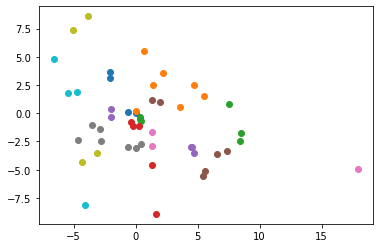

In [13]:
plt.scatter([0], [0])
for g in fin_groups:
    plt.scatter([emp_coords[add][0] for add in g], [emp_coords[add][1] for add in g])

In [18]:
individual_dist = sum(list(tgt_dist_mat.values()))
individual_dist

371.2684

In [19]:
path_lengths = [path_distance(path, emp_dist_mat, tgt_dist_mat) for path in fin_groups]

In [20]:
carpool_dist = sum(path_lengths)
carpool_dist

224.65149999999997

In [27]:
def individual_distances(group, tgt_distance_matrix):
    dist = 0
    for add in group:
        dist+=tgt_distance_matrix[add]
    return dist

In [17]:
full_map = folium.Map(location=[tgt_point.latitude, tgt_point.longitude], zoom_start=11)
folium.Marker([tgt_point.latitude, tgt_point.longitude]).add_to(full_map)
for cur_point in emp_points.values():
    folium.Circle(radius = 10, location=[cur_point.latitude, cur_point.longitude], color='red', fill=True).add_to(full_map)
full_map

In [34]:
group_pos = 1
g = fin_groups[group_pos]
g

['1 Route de Verbin,  74230',
 '1 Chemin du Crêt du Faux,  74290',
 '1 Chemin de Chantapot,  74290']

In [35]:
share_distance = path_distance(g, emp_dist_mat, tgt_dist_mat)
share_distance

19.848

In [36]:
ind_distance = individual_distances(g, tgt_dist_mat)
ind_distance

41.1951

In [41]:
full_map = folium.Map(location=[tgt_point.latitude, tgt_point.longitude], zoom_start=11, width='50%', height='50%')
folium.Marker([tgt_point.latitude, tgt_point.longitude]).add_to(full_map)
for cur_point in g:
    folium.Circle(radius = 10, location=[emp_points[cur_point].latitude, emp_points[cur_point].longitude], color='red', fill=True).add_to(full_map)
print('Total individual distances: {:.2f}'.format(ind_distance))
print('Carpooling distance: {:.2f}'.format(share_distance))
full_map

Total individual distances: 41.20
Carpooling distance: 19.85


In [44]:
import aiohttp
import asyncio

from aiohttp import ClientSession

In [137]:
async def get_route_distance_optimised(address_point_a, address_point_b, session):
    '''
    uses OSRM API to calculate 'car' distance between two points
    result returned in km
    :param address_point_a:
    :param address_point_b:
    :return:
    '''
    
    api_base_str = 'http://router.project-osrm.org/route/v1/driving/'
    getStr = '{}/{},{};{},{}?overview=false'.format(api_base_str, address_point_a.longitude, address_point_a.latitude,
                                                    address_point_b.longitude, address_point_b.latitude)

    optRoute = await session.request(method='GET', url=getStr)
    optRoute_json = await optRoute.json()

    return optRoute_json['routes'][0]['distance'] / 1000.0

async def get_employees_distance_to_target_optimised(employee_points, target_point):
    '''
    :param employee_points:
    :param target_point:
    :return:
    '''
    emp_list = list(employee_points.keys())
    async with ClientSession() as session:
        ret_list = await asyncio.gather(*[get_route_distance_optimised(employee_points[emp], target_point, session) for emp in emp_list])
    dist = {emp_list[k]: ret_list[k] for k in range(len(emp_list))}
    return dist

async def get_employees_distance_matrix_optimised(employee_points):
    adds = list(employee_points.keys())
    num_emp = len(adds)
    print(num_emp)
    dist = np.ndarray((num_emp, num_emp))
    async with ClientSession() as session:
        ret_list = await asyncio.gather(*[get_route_distance_optimised(employee_points[adds[i]], employee_points[adds[j]], session) for i in range(num_emp-1) for j in range(i+1, num_emp)])
        print(len(ret_list))
    for i in range(num_emp):
        dist[i, i] = 0
        for j in range(i+1, num_emp):
            print('i: {}, j: {}'.format(i,j))
            dist[i, j] = ret_list[i*(num_emp-1)+j-1]
            dist[j, i] = dist[i, j]
    res = {adds[i]: {adds[j]: dist[i, j] for j in range(num_emp)} for i in range(num_emp)}
    return res

In [138]:
simul_count = 10
emp_points_test = {k:emp_points[k] for k in list(emp_points.keys())[:simul_count]}
emp_points_test

{'1 Route de Thônes,  74940': <addressPoint.AddressPoint at 0x1d6662f3a90>,
 '1 Chemin du Roc de Chère,  74290': <addressPoint.AddressPoint at 0x1d65f9b7550>,
 '1 A 41,  74960': <addressPoint.AddressPoint at 0x1d65f9b76d0>,
 '1 Voie des Aravis,  74940': <addressPoint.AddressPoint at 0x1d6662f3f40>,
 '1 D 41,  74320': <addressPoint.AddressPoint at 0x1d65f9d2220>,
 "1 Chemin de l'Abbaye,  74940": <addressPoint.AddressPoint at 0x1d65f9c21f0>,
 '1 Route du Parroi,  74600': <addressPoint.AddressPoint at 0x1d6663139d0>,
 '1 Route de Verbin,  74230': <addressPoint.AddressPoint at 0x1d666313c10>,
 '1 Route de Bovagne,  74330': <addressPoint.AddressPoint at 0x1d6663133a0>,
 '1 Chemin sur les Fours,  74600': <addressPoint.AddressPoint at 0x1d666313e50>}

In [139]:
s_time = time.time()
emp_dist_mat_test = await get_employees_distance_matrix_optimised(emp_points_test)
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))
emp_dist_mat_test

10
45
i: 0, j: 1
i: 0, j: 2
i: 0, j: 3
i: 0, j: 4
i: 0, j: 5
i: 0, j: 6
i: 0, j: 7
i: 0, j: 8
i: 0, j: 9
i: 1, j: 2
i: 1, j: 3
i: 1, j: 4
i: 1, j: 5
i: 1, j: 6
i: 1, j: 7
i: 1, j: 8
i: 1, j: 9
i: 2, j: 3
i: 2, j: 4
i: 2, j: 5
i: 2, j: 6
i: 2, j: 7
i: 2, j: 8
i: 2, j: 9
i: 3, j: 4
i: 3, j: 5
i: 3, j: 6
i: 3, j: 7
i: 3, j: 8
i: 3, j: 9
i: 4, j: 5
i: 4, j: 6
i: 4, j: 7
i: 4, j: 8
i: 4, j: 9
i: 5, j: 6


IndexError: list index out of range

In [119]:
test = ['i={}, j={}'.format(i,j) for i in range(5) for j in range(i+1,5)]

In [120]:
s_time = time.time()
emp_dist_tgt_test = await get_employees_distance_to_target_optimised(emp_points, tgt_point)
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))
emp_dist_tgt_test

full time: 3.52


{'1 Route de Thônes,  74940': 7.8077,
 '1 Chemin du Roc de Chère,  74290': 10.8329,
 '1 A 41,  74960': 3.8326,
 '1 Voie des Aravis,  74940': 6.2692,
 '1 D 41,  74320': 2.1437,
 "1 Chemin de l'Abbaye,  74940": 2.7124,
 '1 Route du Parroi,  74600': 12.1823,
 '1 Route de Verbin,  74230': 12.414399999999999,
 '1 Route de Bovagne,  74330': 13.9348,
 '1 Chemin sur les Fours,  74600': 5.1796999999999995,
 '1 Pont de Tasset,  74960': 2.1431,
 "1 Avenue d'Albigny,  74000": 1.6251,
 '1 Poisy,  74330': 6.2217,
 '1 Chemin des Rippes,  74330': 7.2478,
 '1 Chemin du Crêt Sedat,  74600': 7.9233,
 '1 complexe sportif de sous-lettraz,  74370': 6.5895,
 '1 Magic Bazar,  74000': 1.1337000000000002,
 '1 Chemin de Sainte-Catherine,  74000': 4.6422,
 '1 Route du Semnoz,  74000': 6.4852,
 '1 Menthon-Saint-Bernard,  74290': 10.2296,
 '1 Rue des Chasseurs,  74000': 0.6512,
 '1 Fleurs,  74000': 0.6427999999999999,
 '1 Rue des Pervenches,  74960': 2.7396,
 '1 Chemin de la Canaud,  74600': 5.9152,
 '1 Route de Mo

In [121]:
len(emp_dist_tgt_test)

50

In [110]:
s_time = time.time()
async with ClientSession() as session:
    ret_list = [get_route_distance_optimised(emp, tgt_point, session) for emp in emp_points.values()]
    ret = await asyncio.gather(*ret_list)
print(ret)
#tgt_dist_mat_opt = await get_employees_distance_to_target_optimised(emp_points, tgt_point)
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))

[7.8077, 10.8329, 3.8326, 6.2692, 2.1437, 2.7124, 12.1823, 12.414399999999999, 13.9348, 5.1796999999999995, 2.1431, 1.6251, 6.2217, 7.2478, 7.9233, 6.5895, 1.1337000000000002, 4.6422, 6.4852, 10.2296, 0.6512, 0.6427999999999999, 2.7396, 5.9152, 8.0877, 6.0173000000000005, 9.7902, 8.5443, 7.752800000000001, 4.4863, 8.367700000000001, 25.4405, 4.981199999999999, 1.8782999999999999, 12.6746, 2.8579, 17.5921, 9.3118, 6.2537, 3.6382, 5.8787, 4.269399999999999, 7.6321, 8.6065, 11.595799999999999, 14.6537, 12.681, 14.127, 10.0733, 2.5827]
full time: 3.10


In [43]:
s_time = time.time()
tgt_dist_mat_new = get_employees_distance_to_target_optimised(emp_points, tgt_point)
e_time = time.time()
f_time = e_time - s_time
print('full time: {:.2f}'.format(f_time))

full time: 15.46
